# CS4035 - Cyber Data Analytics
## Lab 2 - PCA/Regression task

## Group Number : 21

## Student 2
### Name : Michał Okoń
### ID :

In [34]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import ccf

In [35]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab2-PCA-Regression.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 484


## 0. Data Loading

#### Loading into pandas dataframe

In [36]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [37]:
# Excluding the time frame and the target variable and backup signals
relevant_signals = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
                    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
                    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'MV101', 'P101', 'MV201', 'P203', 'P205', 'MV301',
                    'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'UV401', 'P501', 'P602']
relevant_train_data_df = train_data_df[relevant_signals]
relevant_train_data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [38]:
test_data_df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Id,,,,,,,,,,,,,,,,,,,,,
224959,31/12/2015 12:29:19 AM,2.612177,517.6261,2,2,1,192.2263,8.530376,324.2758,2.443597,...,0.306825,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224960,31/12/2015 12:29:20 AM,2.612177,517.7831,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224961,31/12/2015 12:29:21 AM,2.594562,518.2149,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,249.9840,0.816967,188.4613,0.0,1,1,1
224962,31/12/2015 12:29:22 AM,2.577907,518.7645,2,2,1,192.2263,8.531017,324.2758,2.442060,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
224963,31/12/2015 12:29:23 AM,2.562854,519.1177,2,2,1,192.2263,8.531017,324.2758,2.441419,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1


## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

Main functions used to perform the PCA and plot the residuals.

In [74]:
def get_pca_residuals(df, components=None):
    total_residuals = []
    if components is None:
        component_range = range(1, len(df.columns))
    else:
        component_range = components
    for n_components in component_range:
        pca = PCA(n_components=n_components)
        pca.fit(df)
        # Calculate residuals
        residuals = calculate_residuals(df, pca)
        total_residuals.append(residuals)
    return total_residuals


def plot_pca_residuals(residuals, components, start_index=0, true_labels=None, predicted_labels=None):
    print(residuals)
    print(true_labels)
    plt.clf()
    x = np.arange(start_index, len(residuals[0]))
    for i, residual in enumerate(residuals):
        plt.plot(x, residual[start_index:], label=f'{components[i]}')
        if true_labels is not None:
            plt.scatter(true_labels, residual[true_labels], label="True anomalies", color="green", s=20)
        if predicted_labels is not None:
            plt.scatter(predicted_labels, residual[predicted_labels], label="Predicted anomalies", color="blue", s=10)
    plt.legend()
    plt.title('PCA Residuals for different number of components')
    plt.show()


def calculate_residuals(df, pca):
    return np.sum(np.abs(df - pca.inverse_transform(pca.transform(df))), axis=1)

Perform the residual analysis.

In [40]:
components = np.arange(1, len(relevant_train_data_df.columns))

In [41]:
residuals = get_pca_residuals(relevant_train_data_df)

In [42]:
partial_components1 = [1, 2, 5]
partial_residuals1 = get_pca_residuals(relevant_train_data_df, components=partial_components1)

In [43]:
partial_components2 = [10, 15, 20]
partial_residuals2 = get_pca_residuals(relevant_train_data_df, components=partial_components2)

In [44]:
partial_components3 = [25, 30, 35]
partial_residuals3 = get_pca_residuals(relevant_train_data_df, components=partial_components3)

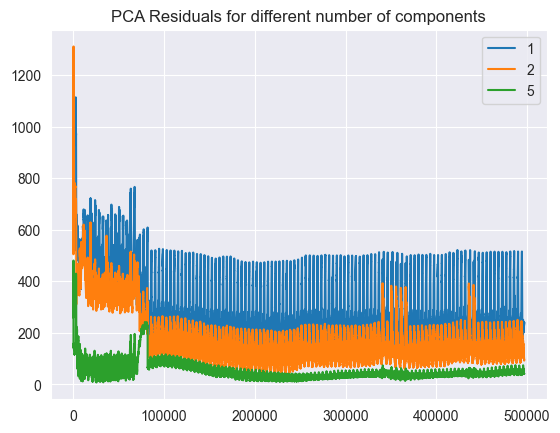

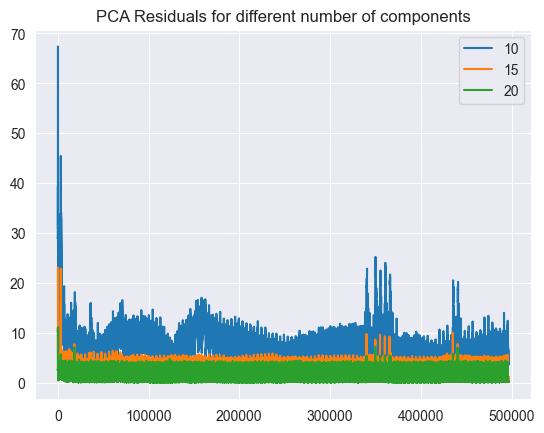

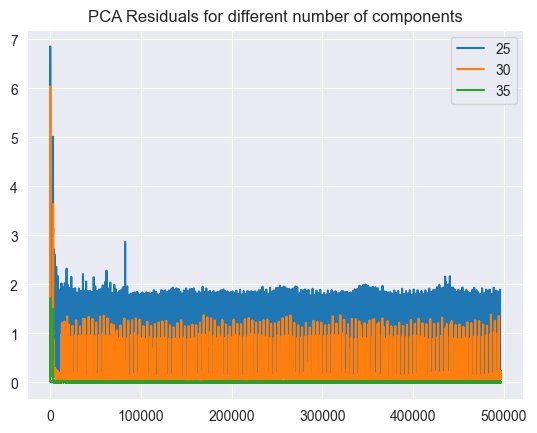

In [45]:
plot_pca_residuals(partial_residuals1, partial_components1, start_index=0)
plot_pca_residuals(partial_residuals2, partial_components2, start_index=0)
plot_pca_residuals(partial_residuals3, partial_components3, start_index=0)

In [46]:
# plot_pca_residuals(residuals, start_index=50000)

Analyzing the residuals in the train set.

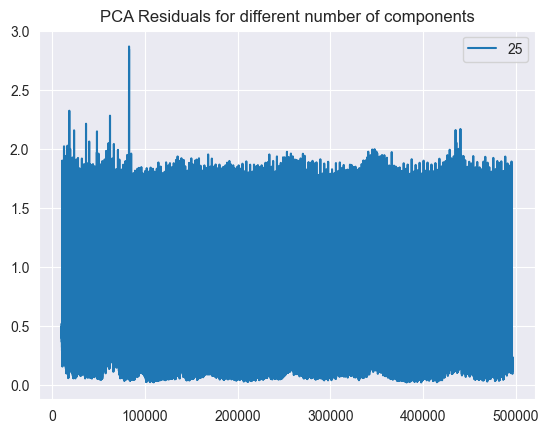

In [47]:
final_components = 25  # 25 good
start_index = 10000
final_pca = PCA(n_components=final_components)
final_pca.fit(relevant_train_data_df)
train_data_pca = final_pca.transform(relevant_train_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_train_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the test set. From the values below, it can be noted that the threshold between 4 and 5 is a good choice as it captures just enough outliers in the data.

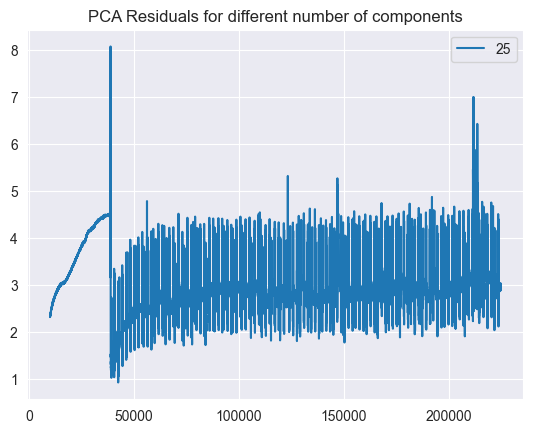

In [48]:
relevant_test_data_df = test_data_df[relevant_signals]

test_data_pca = final_pca.transform(relevant_test_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_test_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

In [49]:
#

Plotting residuals from the validation dataset and marking anomalies (red dashed vertical lines). As can be seen, some anomalies are properly detected. This is used to verify the submission for kaggle.

[Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64]
[  1754   1755   1756 ... 199738 199739 199740]


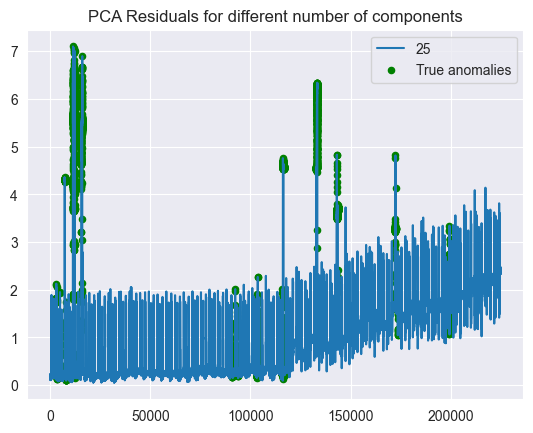

In [75]:
relevant_validation_data_df = val_data_df[relevant_signals]
validation_data_pca = final_pca.transform(relevant_validation_data_df)
# Calculate residuals
validation_residuals = calculate_residuals(relevant_validation_data_df, final_pca)

# Get indices of anomalies
anomaly_indices = np.where((val_data_df['Label'].to_numpy() == 1))[0]
plot_pca_residuals([validation_residuals], components=[final_components], start_index=0, true_labels=anomaly_indices)

Defining the allowed range for each of the signal which is set to be (1.5 * smallest_signal_residual, 1.5 * largest_signal_residual) to provide some safety margin. If the residual of a signal is out of this range, then the signal is considered an anomaly.

In [63]:
def calculate_thresholds(residuals, range_multiplier=1.5):
    return residuals.max() * range_multiplier


start_signal = 10000
trimmed_train_data_df = relevant_train_data_df.iloc[start_signal:, :]
train_residuals = calculate_residuals(trimmed_train_data_df, final_pca)
threshold = calculate_thresholds(train_residuals, range_multiplier=1.5)
print(threshold)

4.301609497302263


In [64]:
print(validation_residuals)

Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64


In [65]:
def find_anomalies_in_residuals(residuals, threshold):
    """
    Returns the set containing indices of anomalies in the residuals.
    """
    anomalies_indices = set()
    # Return indices where the residual is out of the allowed range using numpy
    for i, residual in enumerate(residuals):
        if residual > threshold:
            anomalies_indices.add(i)
    return anomalies_indices


predicted_anomalies = list(find_anomalies_in_residuals(validation_residuals, threshold))


[Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64]
[  1754   1755   1756 ... 199738 199739 199740]


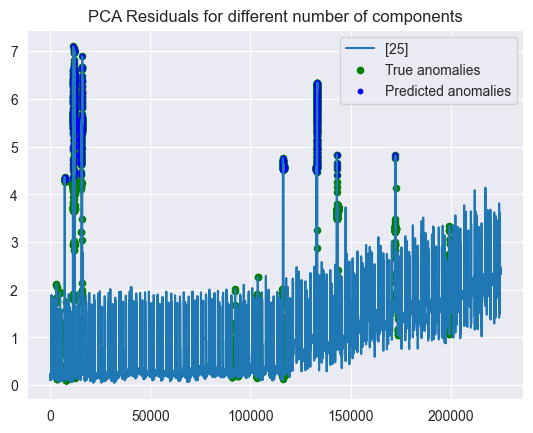

In [76]:
plot_pca_residuals([validation_residuals], components=[[25]], start_index=0, true_labels=anomaly_indices,
                   predicted_labels=predicted_anomalies)

Calculate metrics for the PCA model.

In [ ]:
# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predicted_anomalies, true_anomalies):
    true_positives = len(set(predicted_anomalies).intersection(set(true_anomalies)))
    false_positives = len(set(predicted_anomalies).difference(set(true_anomalies)))
    true_negatives = len(
        set(np.arange(len(validation_residuals.index))).difference(set(predicted_anomalies).union(set(true_anomalies))))
    false_negatives = len(set(true_anomalies).difference(set(predicted_anomalies)))
    return true_positives, false_positives, true_negatives, false_negatives


tp, fp, tn, fn = calculate_statistics(predicted_anomalies, anomaly_indices)
print(f"True positives: {tp}, False positives: {fp}, True negatives: {tn}, False negatives: {fn}")


def calculate_metrics(tp, fp, tn, fn):
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score


accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}")


Analyze several thresholds. Turns out that multiplying the max and min values in the train set by 4 gives the best results.

In [ ]:
def analyze_thresholds(residuals, true_anomalies, thresholds, range_multipliers):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    for i, threshold in enumerate(thresholds):
        predicted_anomalies = list(find_anomalies_in_residuals(residuals, threshold))
        tp, fp, tn, fn = calculate_statistics(predicted_anomalies, true_anomalies)
        accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        print(
            f"Threshold multiplier: {range_multipliers[i]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}\n")
    return accuracies, precisions, recalls, f1_scores


threshold_multipliers = np.arange(0.4, 3, 0.2)
thresholds = [calculate_thresholds(train_residuals, range_multiplier=multiplier) for multiplier in
              threshold_multipliers]
accuracies, precisions, recalls, f1_scores = analyze_thresholds(validation_residuals, anomaly_indices, thresholds,
                                                                threshold_multipliers)

In [ ]:
# Find anomalies in the test data
test_residuals = calculate_residuals(relevant_test_data_df, final_pca)
test_threshold = 4.8
test_anomalies = np.array(find_anomalies_in_residuals(test_residuals, test_threshold)) + start_index

# Create an array with all the original indices and test anomalies as labels
test_labels = np.zeros(len(test_residuals) + start_index)
test_labels[test_anomalies] = 1
# Create a dataframe with the indices of the anomalies
test_anomalies_df = pd.DataFrame([np.arange(len(test_residuals) + start_index), test_labels], columns=["index", "ore"])
# Put the anomalies in a dataframe
print(test_anomalies)

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

FIT101 displays interesting temporal behavior.

### 4a. Print relevant plots and/or metrics to determine the parameters.

In [79]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

start_index = 10000
relevant_train_data_df = train_data_df.iloc[start_index:, :].copy()
relevant_val_data_df = val_data_df.iloc[start_index:, :].copy()
relevant_test_data_df = test_data_df.iloc[start_index:, :].copy()

<Figure size 640x480 with 0 Axes>

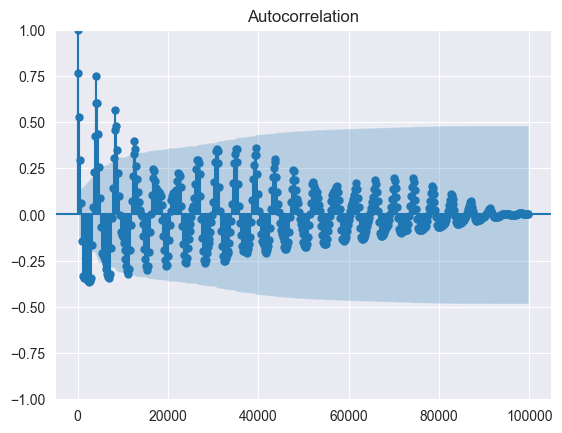

In [37]:
# Plot the autocorrelations for the relevant attributes
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time, :], lags=list(range(0, plotting_time, 200)))
plt.show()

As can be seen in the plot above, the signal shows some cyclic behavior.

In [5]:
from statsmodels.tsa.stattools import acf

fit101_acf = acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time, :], nlags=plotting_time)[::200]
# Find 10 largest values in the acf
print(fit101_acf)
largest_acf_values = np.argsort(fit101_acf, axis=0)[-10:]
print(f"10 largest values in the acf: {largest_acf_values * 200}")

[ 1.00000000e+00  7.63081602e-01  5.29141835e-01  2.93594062e-01
  6.37937413e-02 -1.44368784e-01 -3.33698395e-01 -3.45618389e-01
 -3.46219512e-01 -3.37306164e-01 -3.41345791e-01 -3.51086139e-01
 -3.59139737e-01 -3.67651123e-01 -3.61817880e-01 -3.41374859e-01
 -1.64781376e-01  3.90559823e-02  2.32262960e-01  4.25688904e-01
  6.04754704e-01  7.47899266e-01  6.04738460e-01  4.33241078e-01
  2.59493779e-01  8.77943172e-02 -6.59622805e-02 -2.07254553e-01
 -2.21167827e-01 -2.31317070e-01 -2.46971393e-01 -2.68492643e-01
 -2.96338113e-01 -3.20137922e-01 -3.38419694e-01 -3.42493694e-01
 -3.19694374e-01 -1.81794002e-01 -1.75066719e-02  1.44884134e-01
  3.07615838e-01  4.56451616e-01  5.65339375e-01  4.76682499e-01
  3.46695518e-01  2.23696564e-01  1.02392699e-01 -1.14062616e-03
 -9.45929348e-02 -1.12301678e-01 -1.23106596e-01 -1.52426487e-01
 -1.93636791e-01 -2.41671099e-01 -2.80088923e-01 -3.05460643e-01
 -3.22134532e-01 -2.97363320e-01 -1.91123203e-01 -5.73468109e-02
  7.53353154e-02  2.07498

In [6]:
start_lag = 1
end_lag = 5001
interval = 500

From the analysis above, we can deduce that the period of this signal is around 4200 as the autocorrelation has a large spike there. Thus, our first attempt will consider lags around this value.

In [18]:
# Use autoregression to predict the next values based on the previous ones

from sklearn.linear_model import ARDRegression


def get_features_targets(time_window_range, data, intervals=1, feature="FIT101"):
    # Collect arrays of the features and labels
    features = []
    targets = []
    signal_array = data[feature].to_numpy().squeeze()
    for i in range(time_window_range, len(data)):
        time_window = np.flip(signal_array[i - time_window_range:i:intervals])
        target = signal_array[i]
        features.append(time_window)
        targets.append(target)

    features = np.array(features)
    targets = np.array(targets)
    return features, targets


def predict_and_plot(features, targets, model):
    predictions = model.predict(features)
    residuals = predictions - targets
    plt.plot(residuals, label="Residuals")
    plt.legend()
    plt.show()


def run_model(time_window_range, data, intervals=1, feature="FIT101"):
    features, targets = get_features_targets(time_window_range, data, intervals, feature)
    ard = ARDRegression()
    ard.fit(features, targets)
    predict_and_plot(features, targets, ard)
    return ard


def get_ar_residuals(targets, predictions):
    return predictions - targets


In [ ]:
ard = ARDRegression()
features, targets = get_features_targets(4200, relevant_train_data_df, intervals=2)

print(features.shape)
print(targets.shape)

In [10]:
# Train the model
ard.fit(features, targets)

KeyboardInterrupt: 

In [8]:
# Plot the coefficients
plt.plot(ard.coef_)

AttributeError: 'ARDRegression' object has no attribute 'coef_'

In [9]:
# Predict the values
predictions = ard.predict(features)
plt.plot(predictions[300000:320000], label="Predictions")
plt.plot(targets[300000:320000], label="Real values")
plt.legend()

NotFittedError: This ARDRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

As can be seen above, the predicted and real values are close to the real ones on larger scale.

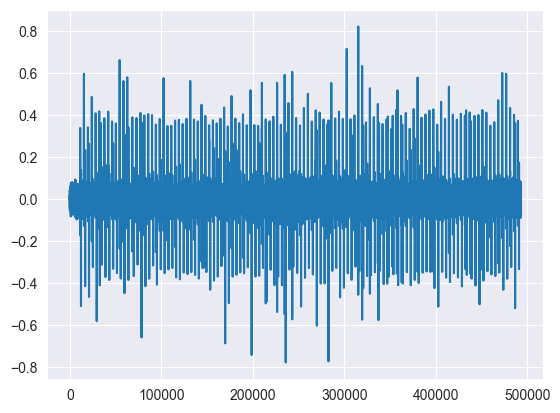

In [31]:
plt.clf()

train_residuals = get_ar_residuals(targets, predictions)
plt.plot(train_residuals)

Now taking the smaller time windows. As we can see, residual look similar.

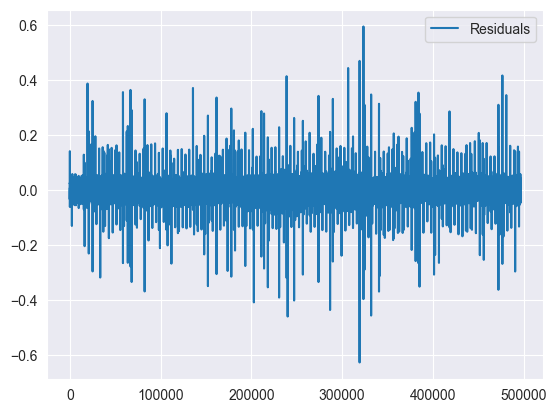

In [33]:
ard_small = run_model(100, relevant_train_data_df)

Taking different signals.

<Figure size 640x480 with 0 Axes>

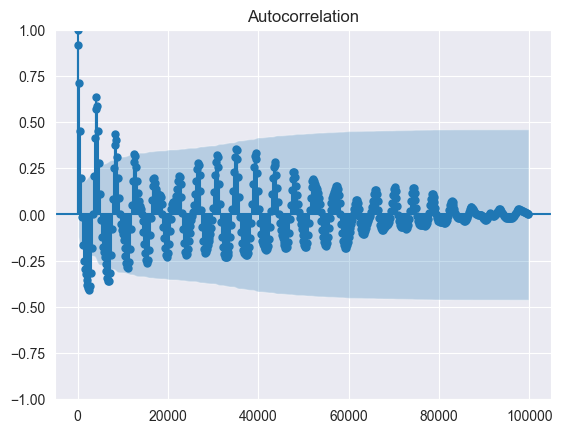

In [41]:
# Plot the autocorrelations for the signal LIT101
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df["LIT101"][: plotting_time], lags=list(range(0, plotting_time, 200)))
plt.show()

plt.clf()
plot_acf(relevant_train_data_df["LIT401"][: plotting_time], lags=list(range(0, plotting_time, 200)))
plt.show()

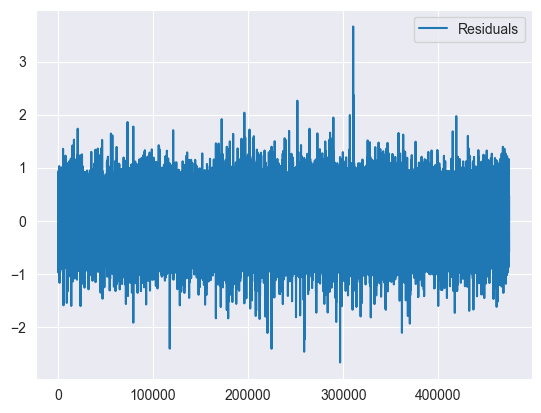

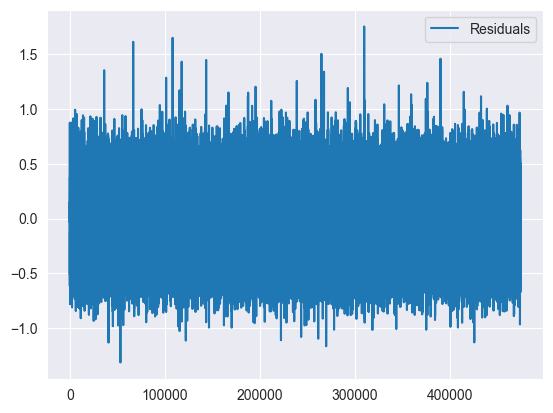

In [42]:
# Continous signals
LIT101_ar = run_model(2200, relevant_train_data_df[10000:], feature="LIT101")
LIT401_ar = run_model(2200, relevant_train_data_df[10000:], feature="LIT401")



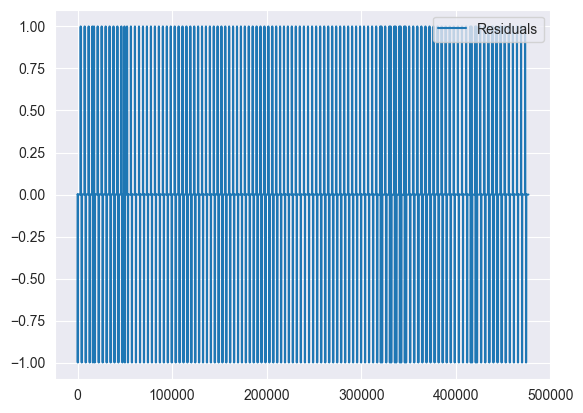

In [14]:
# Binary signals
P101_ar = run_model(100, relevant_train_data_df[10000:], feature="P101")

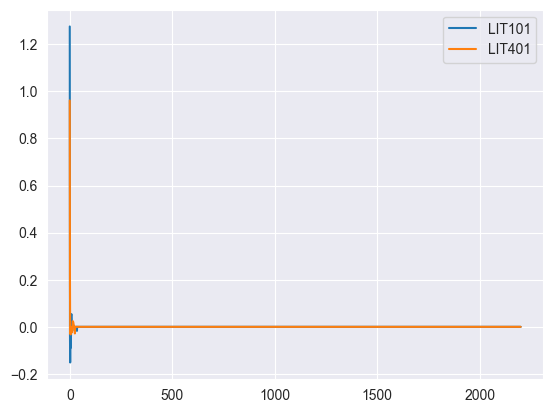

In [43]:
# Plot the coefficients
plt.clf()
plt.plot(LIT101_ar.coef_, label="LIT101")
plt.plot(LIT401_ar.coef_, label="LIT401")
plt.legend()
plt.show()

Applying differencing.

Id
10000          NaN
10001    -0.005445
10002     0.000000
10003     0.028505
10004     0.049002
            ...   
496795   -0.011209
496796   -0.011530
496797   -0.014092
496798   -0.006406
496799   -0.001281
Name: FIT101_diff, Length: 486800, dtype: float64


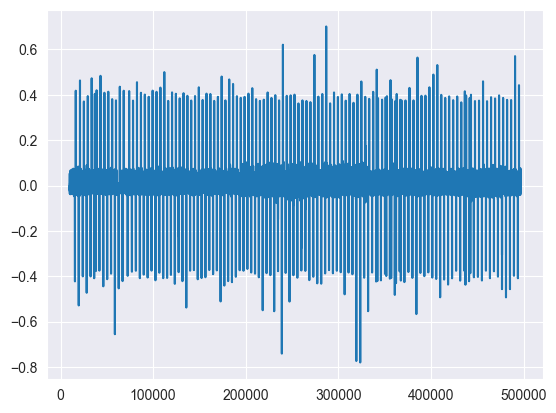

In [80]:
relevant_train_data_df["FIT101_diff"] = relevant_train_data_df["FIT101"].diff()
print(relevant_train_data_df["FIT101_diff"])
# Replace nan with zero
relevant_train_data_df["FIT101_diff"] = relevant_train_data_df["FIT101_diff"].fillna(0)

plt.plot(relevant_train_data_df["FIT101_diff"])
plt.show()

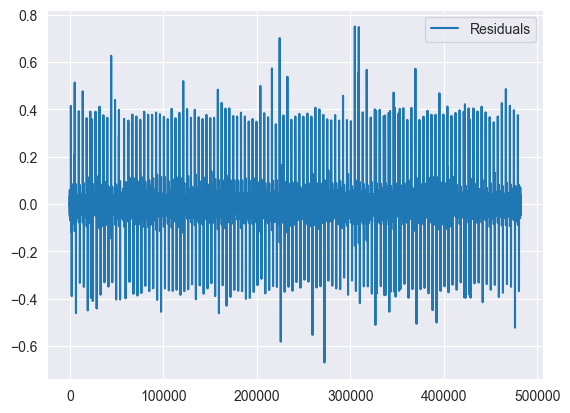

In [81]:
# Training the model
ard_FIT101_diff = run_model(4400, relevant_train_data_df, feature="FIT101_diff", intervals=5)

Residuals confirm that the difference between the predicted and true values is rather small. We will now look at a model that only uses small values of lags.

Interestingly, this model is a much better fit than the ones using larger time windows. This might due to the fact that the correlation between signals is much stronger for smaller lags. We will now use differencing to calculate the residuals.

In this case, the signals are autocorrelated withing a very short time frame. Thus, we will use a small lag for the autoregression model.

The predictive power has not increased. One of the possible causes is that the signal is not periodic enough and the differencing does not help to make it more periodic. We will now look at the signal LIT101.

Again, the small difference between the smaller and larger time windows shows that the signal is not periodic enough to make a long-term prediction useful.

### 4b. Plots to study the detected anomalies

In [107]:
# Plot the anomalies
def find_anomalies(residuals, threshold):
    return np.where(np.abs(residuals) > threshold)[0]

def plot_threshold(residuals, threshold, true_anomalies=None, predicted_anomalies=None):
    plt.plot(residuals, label="Residual")
    plt.hlines(threshold, 0, len(residuals), label="Threshold", linestyle="--", color="red")
    plt.hlines(-threshold, 0, len(residuals), linestyle="--", color="red")

    if true_anomalies is not None:
        plt.scatter(true_anomalies, residuals[true_anomalies], label="True anomalies", color="green", s=20)

    if predicted_anomalies is not None:
        plt.scatter(predicted_anomalies, residuals[predicted_anomalies], label="Predicted anomalies", color="blue",
                    s=10)
    plt.legend()
    plt.show()


features, targets = get_features_targets(100, relevant_train_data_df)

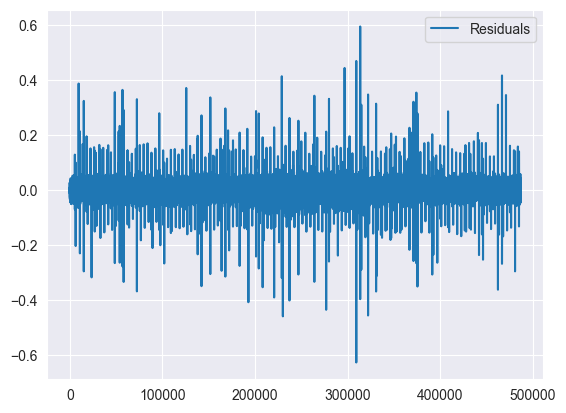

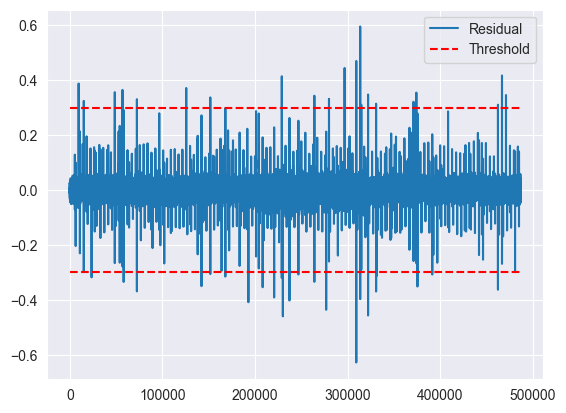

In [108]:
# Using the FIT101 signal
threshold = 0.3
ard_final = run_model(100, relevant_train_data_df)
train_residuals = get_ar_residuals(targets, ard_final.predict(features))
plot_threshold(train_residuals, threshold)


In [115]:
def validate_results(train_data, val_data, time_window_range, signal, threshold=None, interval=1):
    val_features, val_targets = get_features_targets(time_window_range, val_data, intervals=interval, feature=signal)
    train_features, train_targets = get_features_targets(time_window_range, train_data, intervals=interval,
                                                         feature=signal)

    model = ARDRegression()
    model.fit(train_features, train_targets)
    if threshold is None:
        train_residuals = get_ar_residuals(train_targets, model.predict(train_features))
        threshold = np.max(np.abs(train_residuals))
    predictions = model.predict(val_features)
    val_residuals = get_ar_residuals(val_targets, predictions)
    predicted_anomalies = find_anomalies(val_residuals, threshold)
    true_anomalies = np.where(relevant_val_data_df["Label"] == 1)[0]
    plot_threshold(val_residuals, threshold, true_anomalies, predicted_anomalies)
    return predicted_anomalies, residuals

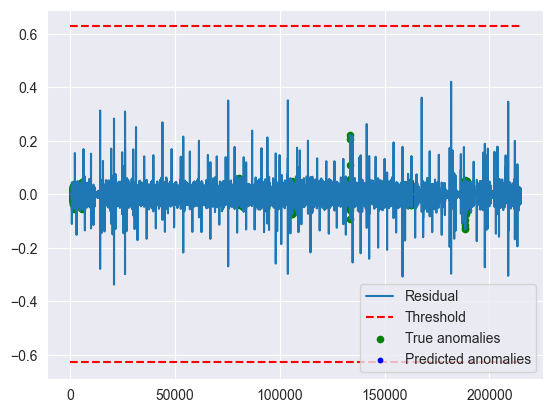

In [116]:
# The validation dataset
validation_signal = "FIT101"

anomalies, residuals = validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

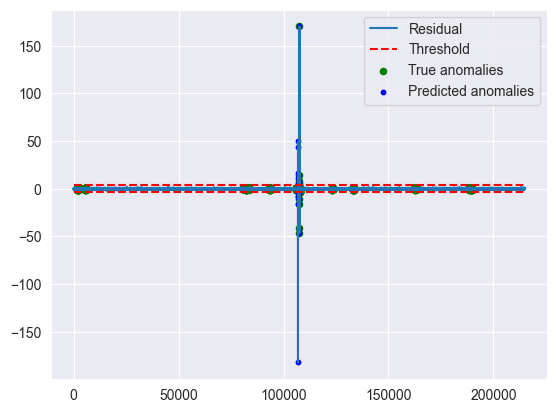

(array([106899, 106900, 106901, 106902, 106903, 106904, 106905, 106906,
        106907, 106909, 107601, 107602, 107603, 107604, 107605, 107606,
        107607, 107608, 107609, 107611], dtype=int64),
 array([ 0.00051115,  0.00051115,  0.00051115, ...,  0.00529294,
         0.01979066, -0.01056333]))

In [117]:
# The validation dataset
validation_signal = "LIT101"

validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

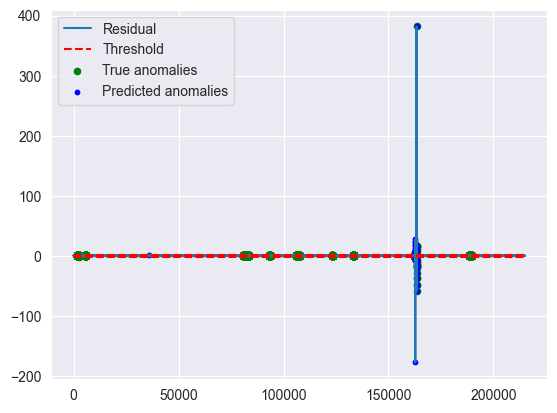

(array([ 36117, 162792, 162793, 162794, 162795, 162796, 162797, 162798,
        162799, 162800, 162801, 162802, 162804, 162805, 162806, 162807,
        162808, 162810, 162811, 162812, 162813, 162814, 162815, 162816,
        162817, 163399, 163400, 163401, 163402, 163403, 163404, 163405,
        163406, 163407, 163408, 163409, 163410, 163411, 163412, 163413,
        163414, 163415, 163417, 163418, 163419, 163420, 163421, 163422,
        163423, 163424], dtype=int64),
 array([ 0.00051115,  0.00051115,  0.00051115, ...,  0.00529294,
         0.01979066, -0.01056333]))

In [118]:
# The validation dataset
validation_signal = "LIT401"

validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

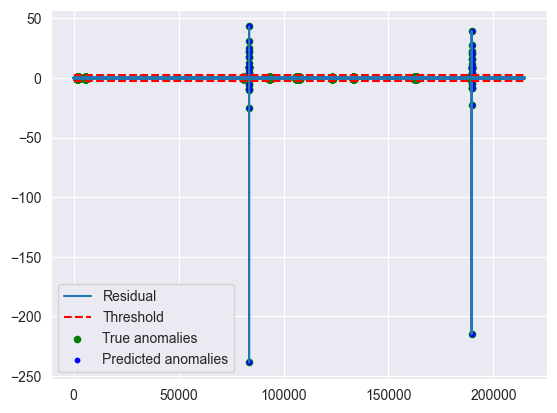

(array([ 83605,  83606,  83607,  83608,  83609,  83610,  83611,  83612,
         83613,  83614,  83615,  83616,  83618,  83619,  83620,  83621,
         83622,  83624,  83625,  83626,  83627,  83628,  83629,  83630,
         83631,  83632, 189616, 189617, 189618, 189619, 189620, 189621,
        189622, 189623, 189624, 189625, 189626, 189627, 189629, 189630,
        189631, 189632, 189633, 189635, 189636, 189637, 189638, 189639,
        189640, 189641, 189642, 189643], dtype=int64),
 array([ 0.00051115,  0.00051115,  0.00051115, ...,  0.00529294,
         0.01979066, -0.01056333]))

In [119]:
# The validation dataset
validation_signal = "LIT301"

validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

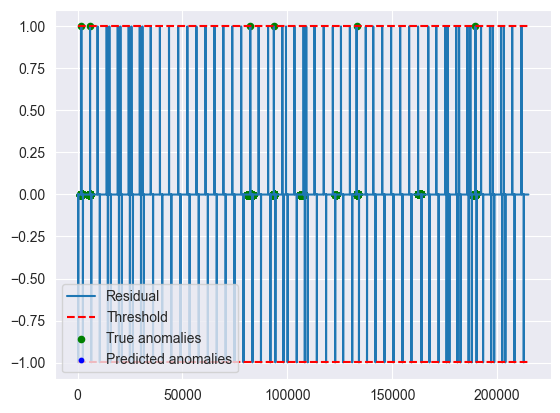

(array([], dtype=int64),
 array([ 0.00051115,  0.00051115,  0.00051115, ...,  0.00529294,
         0.01979066, -0.01056333]))

In [120]:
# Try out binary signals
validation_signal = "P101"
validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

### 4c. Analysis and answers to the questions